In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

✅ Phase 1 & 2 results loaded.

CROSS-DATASET COMPARISON: LEUKEMIA vs BREAST CANCER
               Metric            Phase 1: Leukemia                     Phase 2: Breast Cancer
       Original Paper Golub et al. (1999), Science                  GSE45827 (Gruosso et al.)
       Dataset Source            Kaggle (crawford)                      GEO / Kaggle (CuMiDa)
             Platform           Affymetrix Hgu6800       Affymetrix HG-U133 Plus 2.0 (GPL570)
        Total Samples                           72                                        151
          Total Genes                         7129                                      54675
    Number of Classes                            2                                          6
          Class Names                     ALL, AML basal, HER2, lumA, lumB, cell_line, normal
    PCA: PC1 Variance                        15.0%                                      17.8%
PCA: PC1+PC2 Variance                        27.0%                     

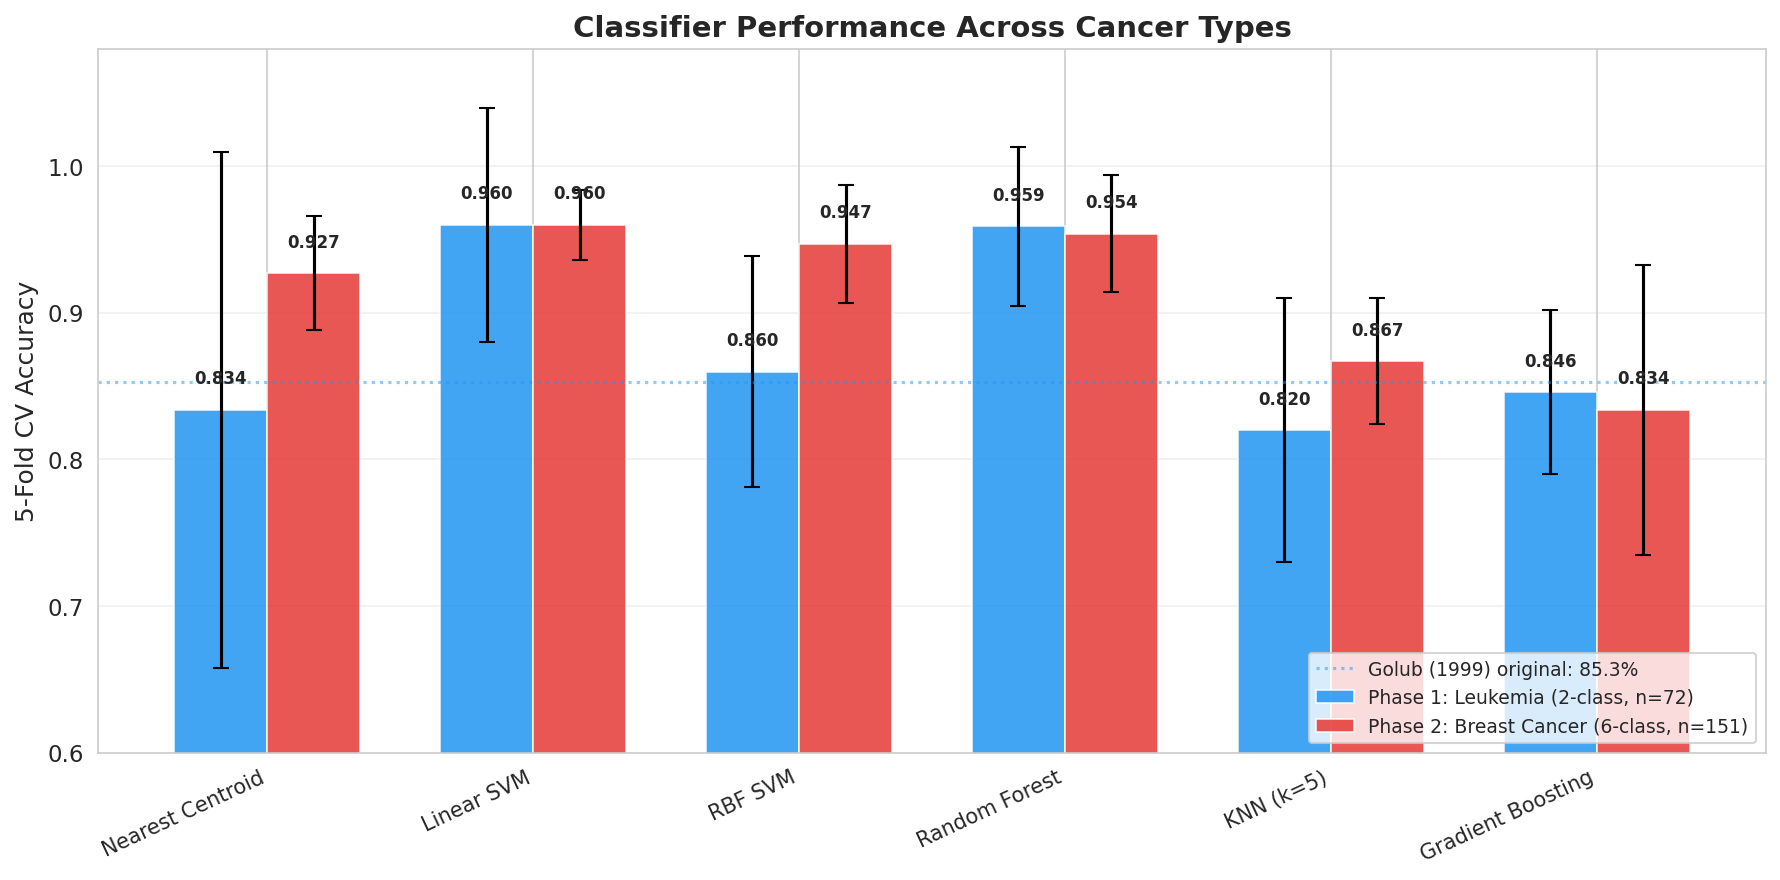

📊 P3 Figure 1: Cross-dataset classifier comparison.


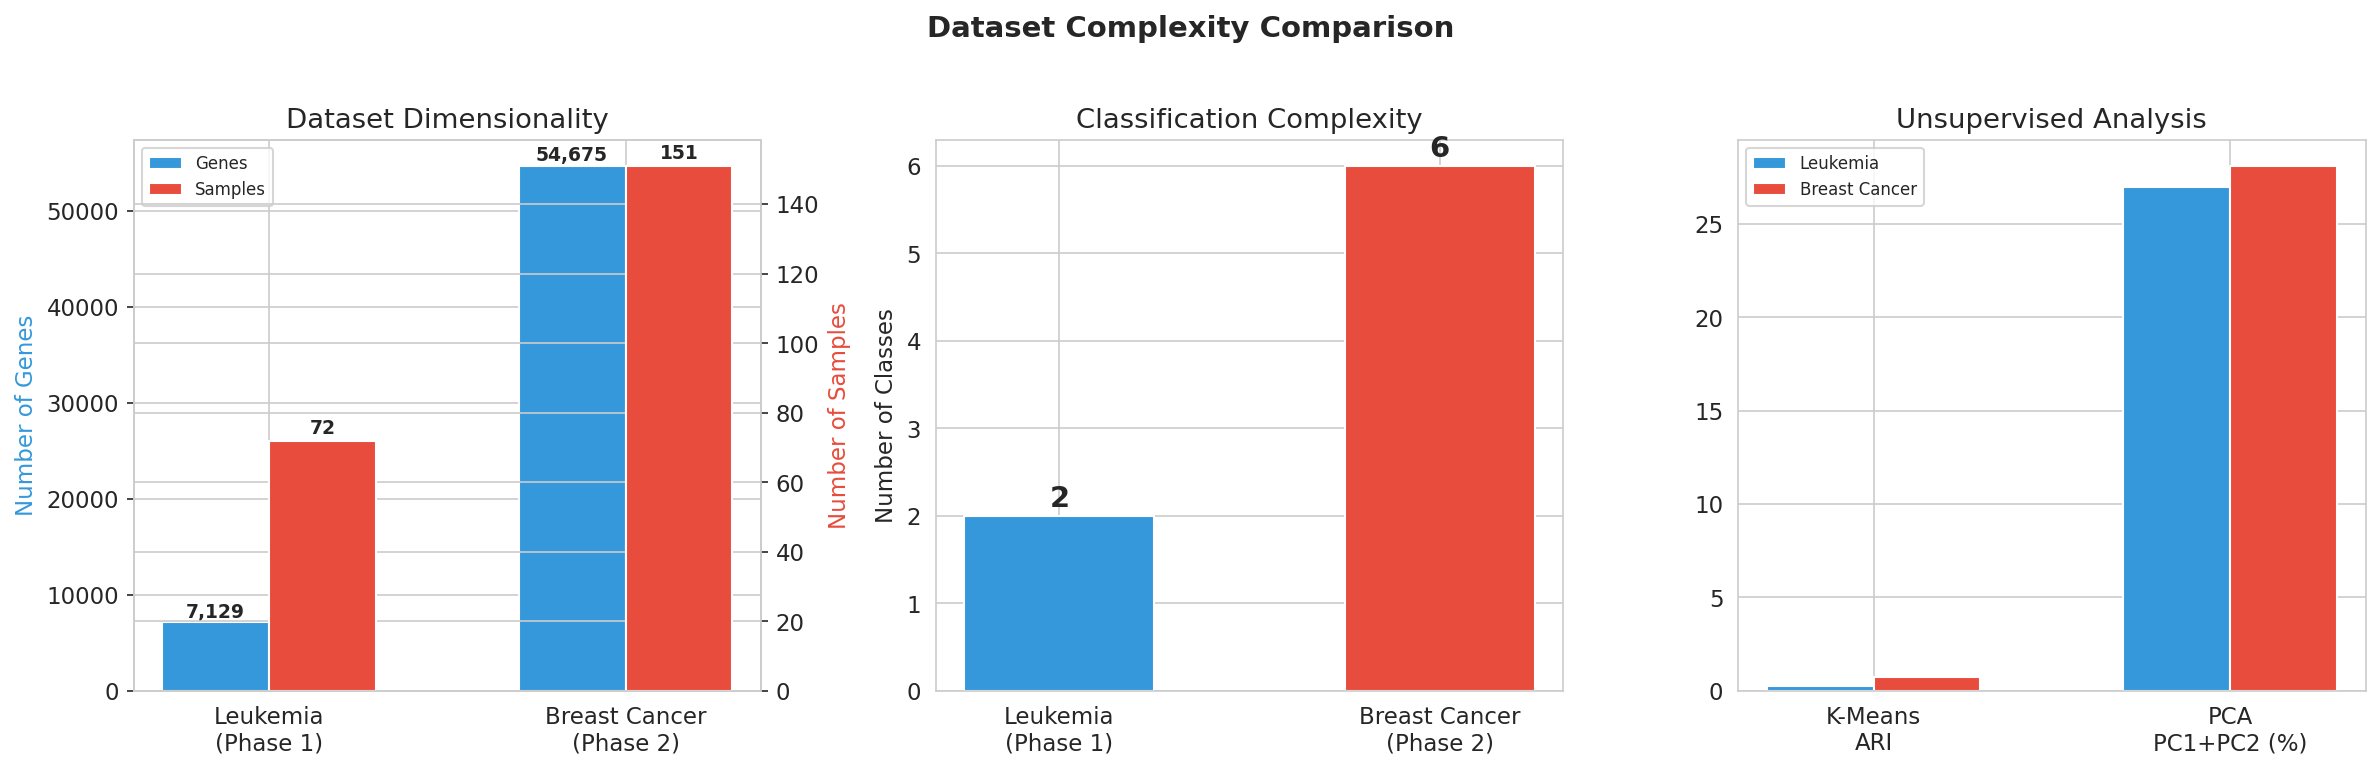

📊 P3 Figure 2: Dataset complexity comparison.


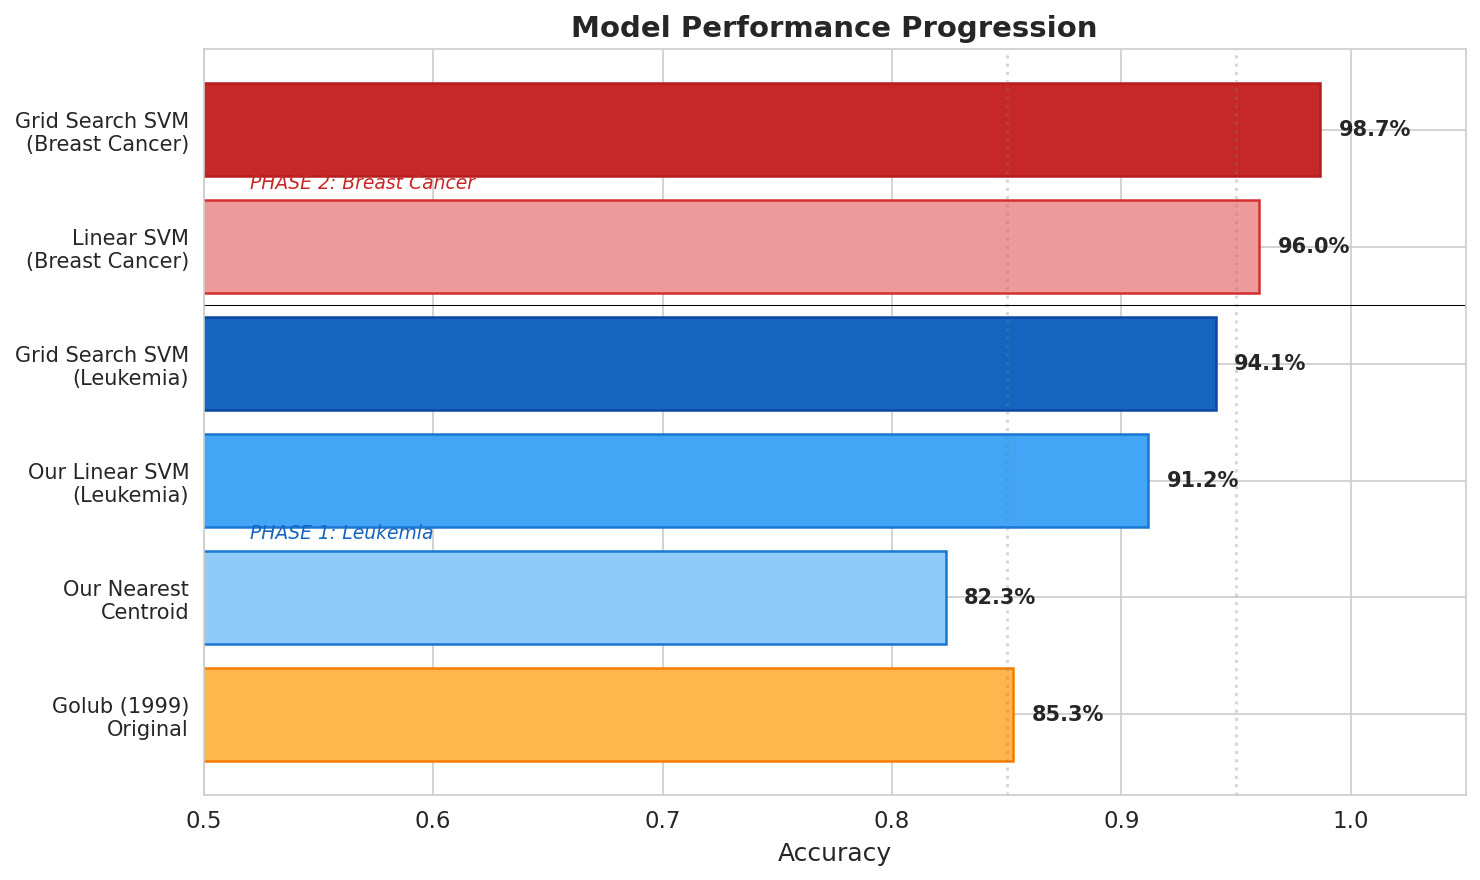

📊 P3 Figure 3: Model performance progression.


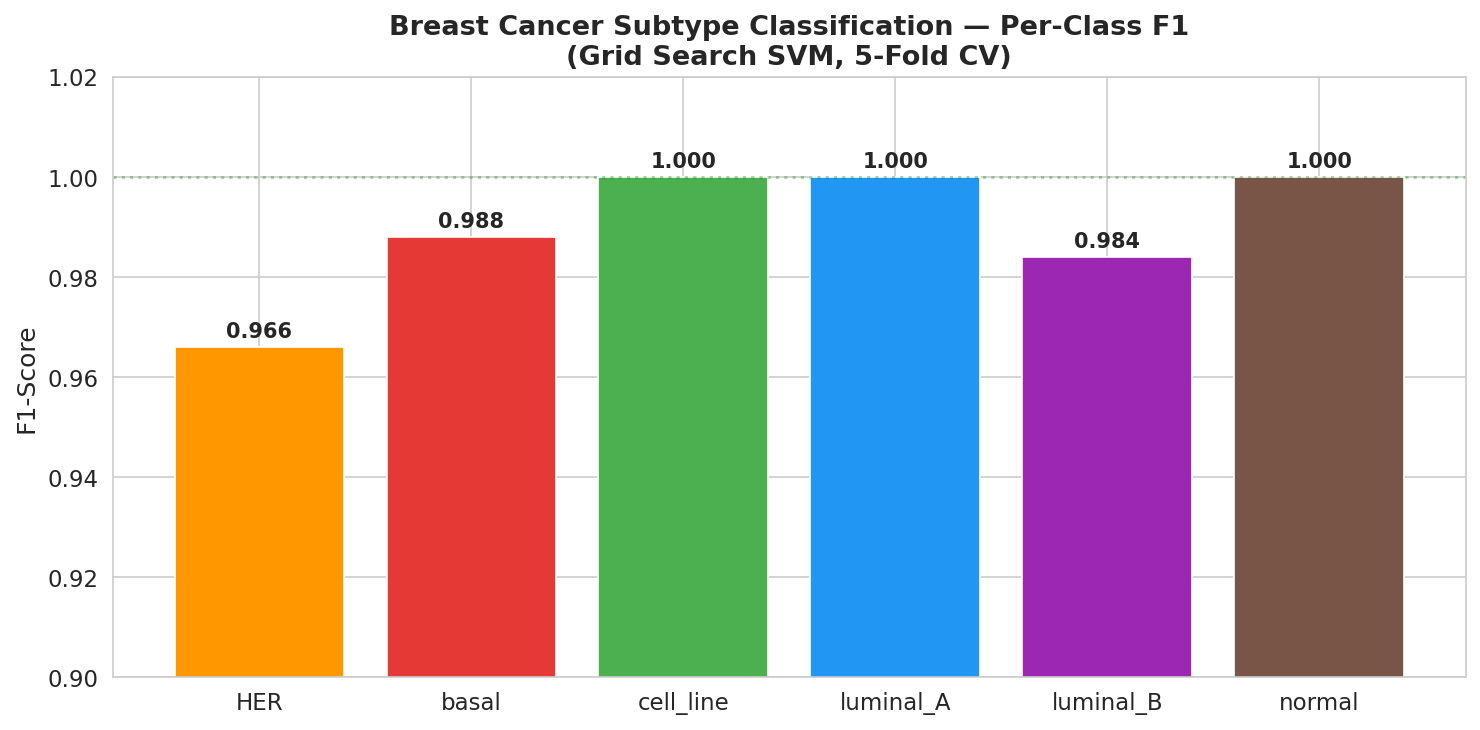

📊 P3 Figure 4: Per-class F1 scores.


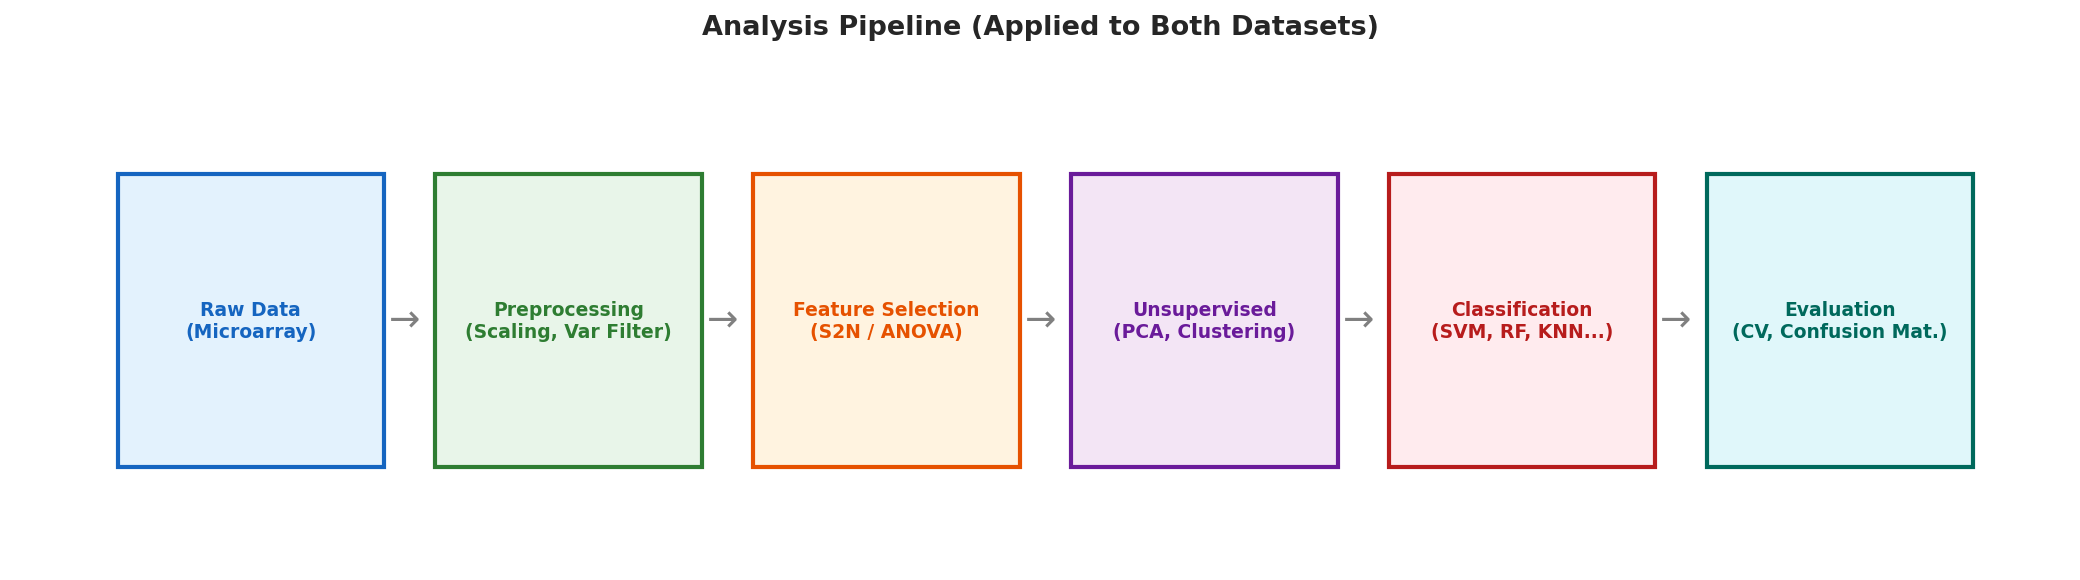

📊 P3 Figure 5: Pipeline overview.


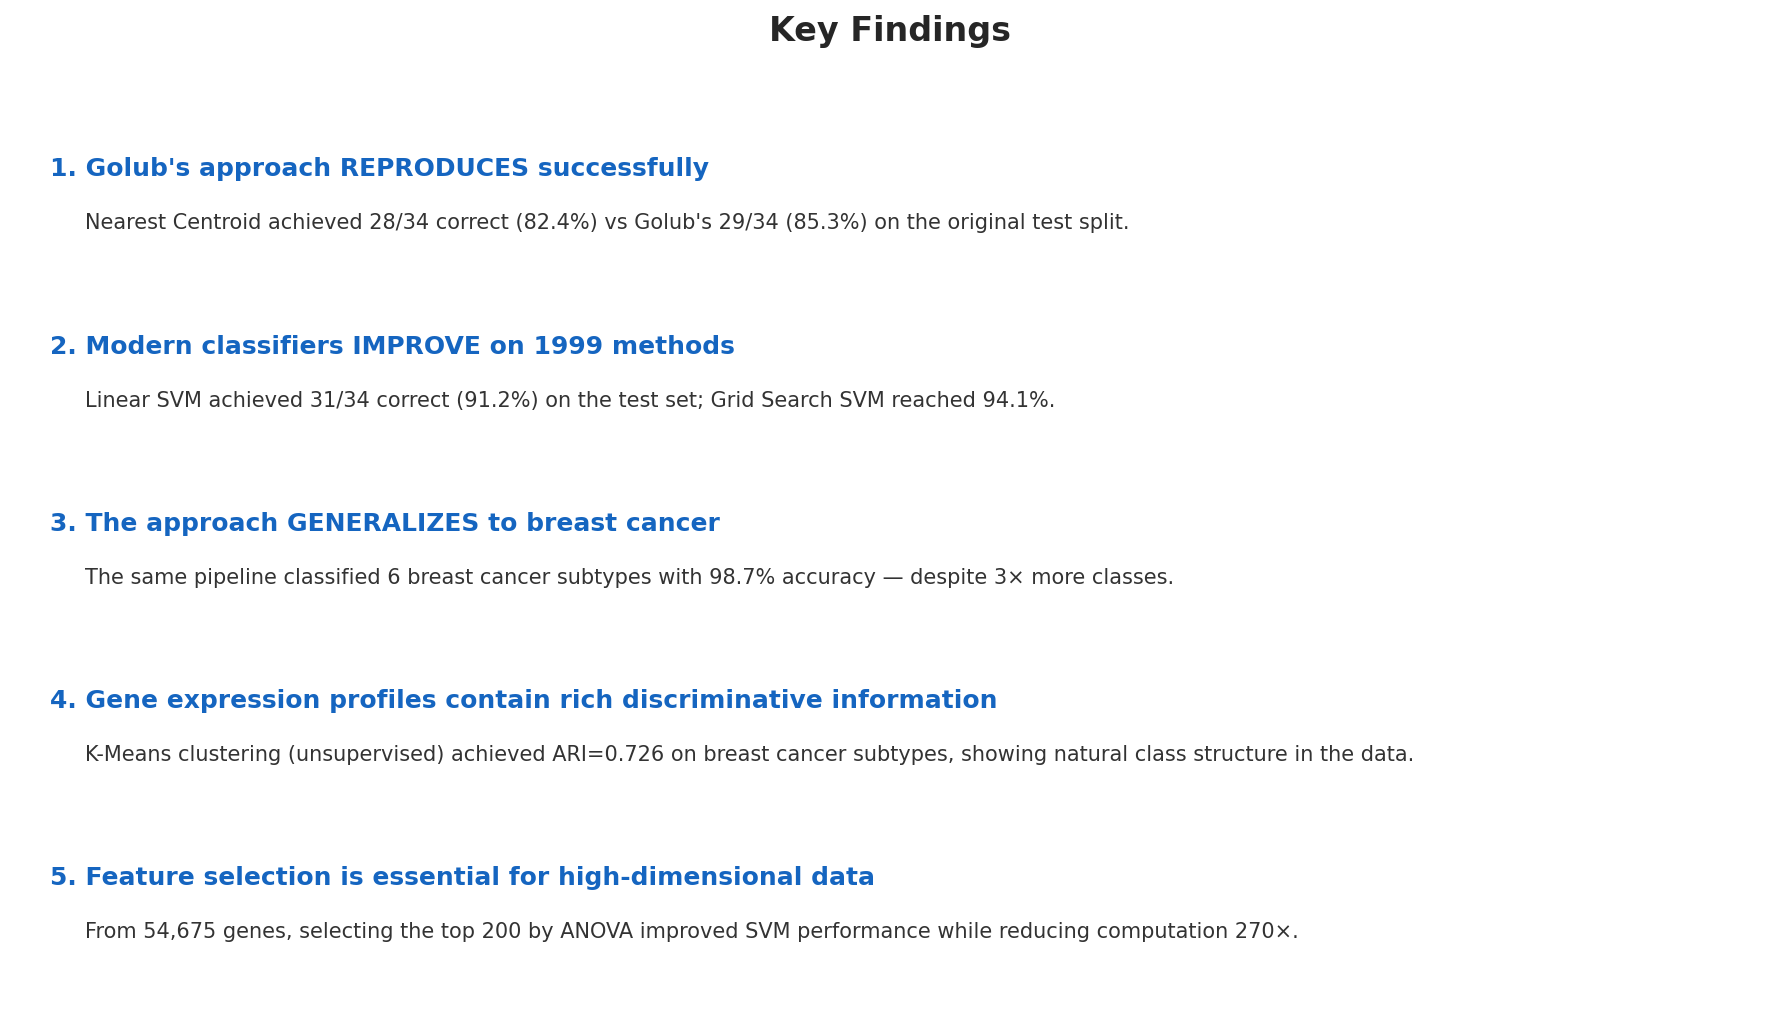

📊 P3 Figure 6: Key findings summary.

PROJECT SUMMARY — FINAL RESULTS

TITLE: Molecular Classification of Cancer by Gene Expression:
       Reproducing Golub et al. (1999) and Generalizing to Breast Cancer

APPROACH: Reproduce a paper's analysis on a different dataset

TOPIC AREA: Gene expression profile analysis + Classification methods

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
PHASE 1 — Golub Leukemia Reproduction
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Dataset:     72 samples (47 ALL, 25 AML), 7,129 genes
  Feature Sel: Signal-to-Noise Ratio (top 50 genes)
  Best Test:   Linear SVM & Gradient Boosting = 91.2% (31/34 correct)
  Best CV:     Linear SVM = 96.0% ± 8.0%
  Grid Search: SVM (C=1, RBF, k=25) = 94.1% on test set
  vs. Golub:   Our Nearest Centroid (82.4%) ≈ Golub's weighted voting (85.3%)
               Modern methods clearly outperform (+6-9%)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#!/usr/bin/env python3
"""
=============================================================================
PHASE 3: Comparative Analysis, Synthesis & Final Deliverables
=============================================================================
This phase brings together Phase 1 (Golub leukemia) and Phase 2 (GSE45827
breast cancer) results into a unified comparative analysis.

KAGGLE SETUP:
  - Add BOTH datasets as inputs:
    1. "gene-expression" by Crawford
    2. "breast-cancer-gene-expression-cumida" by Bruno Grisci
  - Paste this entire script into a new notebook or append to Phase 2 notebook
=============================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 11
sns.set_style("whitegrid")

# ============================================================================
# SECTION A: Hardcoded results from Phase 1 and Phase 2
# ============================================================================
# These are YOUR actual results extracted from the notebooks.
# If any values changed on re-runs, update them here.

# --- Phase 1: Golub Leukemia ---
P1 = {
    'dataset': 'Golub et al. (1999)',
    'accession': 'Kaggle: crawford/gene-expression',
    'platform': 'Affymetrix Hgu6800',
    'n_samples': 72,
    'n_genes': 7129,
    'n_classes': 2,
    'classes': ['ALL', 'AML'],
    'class_sizes': {'ALL': 47, 'AML': 25},
    'pca_pc1': 15.0,
    'pca_pc2': 12.0,
    'pca_cumulative_5': 43.1,
    'kmeans_ari': 0.260,
    'snr_anova_overlap': 31,
    # Test split results (38 train → 34 test)
    'test_results': {
        'Nearest Centroid':    {'acc': 0.8235, 'correct': '28/34'},
        'Logistic Reg. (L1)':  {'acc': 0.8824, 'correct': '30/34'},
        'Logistic Reg. (L2)':  {'acc': 0.8824, 'correct': '30/34'},
        'Linear SVM':          {'acc': 0.9118, 'correct': '31/34'},
        'RBF SVM':             {'acc': 0.6176, 'correct': '21/34'},
        'Random Forest':       {'acc': 0.7353, 'correct': '25/34'},
        'KNN (k=5)':           {'acc': 0.7059, 'correct': '24/34'},
        'Gradient Boosting':   {'acc': 0.9118, 'correct': '31/34'},
    },
    'golub_original': {'acc': 0.8529, 'correct': '29/34'},
    # 5-Fold CV results
    'cv_results': {
        'Nearest Centroid':    {'mean': 0.834, 'std': 0.176},
        'Logistic Reg. (L1)':  {'mean': 0.863, 'std': 0.146},
        'Logistic Reg. (L2)':  {'mean': 0.905, 'std': 0.123},
        'Linear SVM':          {'mean': 0.960, 'std': 0.080},
        'RBF SVM':             {'mean': 0.860, 'std': 0.079},
        'Random Forest':       {'mean': 0.959, 'std': 0.054},
        'KNN (k=5)':           {'mean': 0.820, 'std': 0.090},
        'Gradient Boosting':   {'mean': 0.846, 'std': 0.056},
    },
    # Grid search best
    'grid_svm': {'acc': 0.9412, 'params': 'C=1, kernel=rbf, k=25'},
    'grid_lr':  {'acc': 0.8824, 'params': 'C=10, penalty=l1, PCA=10'},
}

# --- Phase 2: GSE45827 Breast Cancer ---
P2 = {
    'dataset': 'GSE45827 (CuMiDa)',
    'accession': 'GEO: GSE45827',
    'platform': 'Affymetrix HG-U133 Plus 2.0 (GPL570)',
    'n_samples': 151,
    'n_genes': 54675,
    'n_genes_var_filtered': 11715,
    'n_classes': 6,
    'classes': ['basal', 'HER2', 'luminal_A', 'luminal_B', 'cell_line', 'normal'],
    'class_sizes': {'basal': 41, 'HER': 30, 'luminal_B': 30, 'luminal_A': 29,
                    'cell_line': 14, 'normal': 7},
    'pca_pc1': 17.8,
    'pca_pc2': 10.3,
    'pca_cumulative_5': 42.7,
    'kmeans_ari': 0.726,
    # 5-Fold CV results
    'cv_results': {
        'Nearest Centroid':    {'mean': 0.927, 'std': 0.039},
        'Logistic Regression': {'mean': 0.927, 'std': 0.049},
        'Linear SVM':          {'mean': 0.960, 'std': 0.024},
        'RBF SVM':             {'mean': 0.947, 'std': 0.040},
        'Random Forest':       {'mean': 0.954, 'std': 0.040},
        'KNN (k=5)':           {'mean': 0.867, 'std': 0.043},
        'Gradient Boosting':   {'mean': 0.834, 'std': 0.099},
    },
    # Grid search best
    'grid_svm': {'acc': 0.9867, 'params': 'C=0.1, kernel=linear, k=200'},
    'grid_lr':  {'acc': 0.9469, 'params': 'C=0.1, penalty=l1, PCA=10'},
    # Per-class performance (best model: grid SVM)
    'per_class_f1': {
        'HER':       0.966,
        'basal':     0.988,
        'cell_line': 1.000,
        'luminal_A': 1.000,
        'luminal_B': 0.984,
        'normal':    1.000,
    },
}

print("✅ Phase 1 & 2 results loaded.")


# ============================================================================
# FIGURE 1: Grand Comparison Table (text printout)
# ============================================================================

print(f"\n{'='*80}")
print(f"CROSS-DATASET COMPARISON: LEUKEMIA vs BREAST CANCER")
print(f"{'='*80}")

comparison = pd.DataFrame({
    'Metric': [
        'Original Paper',
        'Dataset Source',
        'Platform',
        'Total Samples',
        'Total Genes',
        'Number of Classes',
        'Class Names',
        'PCA: PC1 Variance',
        'PCA: PC1+PC2 Variance',
        'K-Means ARI',
        'Best CV Accuracy',
        'Best Classifier',
        'Best Grid Search Acc',
    ],
    'Phase 1: Leukemia': [
        'Golub et al. (1999), Science',
        'Kaggle (crawford)',
        P1['platform'],
        P1['n_samples'],
        P1['n_genes'],
        P1['n_classes'],
        'ALL, AML',
        f"{P1['pca_pc1']}%",
        f"{P1['pca_pc1'] + P1['pca_pc2']}%",
        P1['kmeans_ari'],
        f"{max(v['mean'] for v in P1['cv_results'].values()):.3f}",
        'Linear SVM',
        P1['grid_svm']['acc'],
    ],
    'Phase 2: Breast Cancer': [
        'GSE45827 (Gruosso et al.)',
        'GEO / Kaggle (CuMiDa)',
        P2['platform'],
        P2['n_samples'],
        P2['n_genes'],
        P2['n_classes'],
        'basal, HER2, lumA, lumB, cell_line, normal',
        f"{P2['pca_pc1']}%",
        f"{P2['pca_pc1'] + P2['pca_pc2']}%",
        P2['kmeans_ari'],
        f"{max(v['mean'] for v in P2['cv_results'].values()):.3f}",
        'Linear SVM',
        P2['grid_svm']['acc'],
    ],
})
print(comparison.to_string(index=False))


# ============================================================================
# FIGURE 2: Side-by-Side Classifier CV Accuracy
# ============================================================================

# Use classifiers present in both phases
shared_classifiers = [
    'Nearest Centroid', 'Linear SVM', 'RBF SVM',
    'Random Forest', 'KNN (k=5)', 'Gradient Boosting'
]

p1_accs = [P1['cv_results'][c]['mean'] for c in shared_classifiers]
p1_stds = [P1['cv_results'][c]['std'] for c in shared_classifiers]
p2_accs = [P2['cv_results'][c]['mean'] for c in shared_classifiers]
p2_stds = [P2['cv_results'][c]['std'] for c in shared_classifiers]

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(shared_classifiers))
width = 0.35

bars1 = ax.bar(x - width/2, p1_accs, width, yerr=p1_stds,
               label='Phase 1: Leukemia (2-class, n=72)',
               color='#2196F3', edgecolor='white', linewidth=0.8,
               capsize=4, alpha=0.85)
bars2 = ax.bar(x + width/2, p2_accs, width, yerr=p2_stds,
               label='Phase 2: Breast Cancer (6-class, n=151)',
               color='#E53935', edgecolor='white', linewidth=0.8,
               capsize=4, alpha=0.85)

# Add Golub's original result line
ax.axhline(y=P1['golub_original']['acc'], color='#2196F3', linestyle=':',
           alpha=0.5, linewidth=1.5, label=f"Golub (1999) original: {P1['golub_original']['acc']:.1%}")

ax.set_xticks(x)
ax.set_xticklabels(shared_classifiers, rotation=25, ha='right', fontsize=10)
ax.set_ylabel('5-Fold CV Accuracy', fontsize=12)
ax.set_title('Classifier Performance Across Cancer Types', fontsize=14, fontweight='bold')
ax.set_ylim(0.6, 1.08)
ax.legend(fontsize=9, loc='lower right')
ax.grid(axis='y', alpha=0.3)

# Value labels
for bars, accs in [(bars1, p1_accs), (bars2, p2_accs)]:
    for bar, acc in zip(bars, accs):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.015,
                f'{acc:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig("p3_fig1_classifier_comparison.png", dpi=200, bbox_inches='tight')
plt.show()
print("📊 P3 Figure 1: Cross-dataset classifier comparison.")


# ============================================================================
# FIGURE 3: Dataset Complexity Comparison (visual summary)
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 3a. Dimensionality comparison
datasets = ['Leukemia\n(Phase 1)', 'Breast Cancer\n(Phase 2)']
genes = [P1['n_genes'], P2['n_genes']]
samples = [P1['n_samples'], P2['n_samples']]

ax = axes[0]
x_pos = np.arange(2)
b1 = ax.bar(x_pos - 0.15, genes, 0.3, color='#3498DB', label='Genes', edgecolor='white')
ax2 = ax.twinx()
b2 = ax2.bar(x_pos + 0.15, samples, 0.3, color='#E74C3C', label='Samples', edgecolor='white')
ax.set_xticks(x_pos)
ax.set_xticklabels(datasets)
ax.set_ylabel('Number of Genes', color='#3498DB')
ax2.set_ylabel('Number of Samples', color='#E74C3C')
ax.set_title('Dataset Dimensionality')
lines = [b1, b2]
labels = ['Genes', 'Samples']
ax.legend(lines, labels, loc='upper left', fontsize=8)
for i, (g, s) in enumerate(zip(genes, samples)):
    ax.text(i - 0.15, g + 500, f'{g:,}', ha='center', fontsize=9, fontweight='bold')
    ax2.text(i + 0.15, s + 2, str(s), ha='center', fontsize=9, fontweight='bold')

# 3b. Classes comparison
ax = axes[1]
class_data = [P1['n_classes'], P2['n_classes']]
colors = ['#3498DB', '#E74C3C']
bars = ax.bar(datasets, class_data, color=colors, edgecolor='white', width=0.5)
ax.set_ylabel('Number of Classes')
ax.set_title('Classification Complexity')
for bar, val in zip(bars, class_data):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            str(val), ha='center', fontweight='bold', fontsize=14)

# 3c. Unsupervised analysis comparison
ax = axes[2]
metrics = ['K-Means\nARI', 'PCA\nPC1+PC2 (%)']
p1_vals = [P1['kmeans_ari'], P1['pca_pc1'] + P1['pca_pc2']]
p2_vals = [P2['kmeans_ari'], P2['pca_pc1'] + P2['pca_pc2']]

x_pos = np.arange(len(metrics))
ax.bar(x_pos - 0.15, p1_vals, 0.3, color='#3498DB', label='Leukemia', edgecolor='white')
ax.bar(x_pos + 0.15, p2_vals, 0.3, color='#E74C3C', label='Breast Cancer', edgecolor='white')
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics)
ax.set_title('Unsupervised Analysis')
ax.legend(fontsize=8)

plt.suptitle('Dataset Complexity Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("p3_fig2_dataset_comparison.png", dpi=200, bbox_inches='tight')
plt.show()
print("📊 P3 Figure 2: Dataset complexity comparison.")


# ============================================================================
# FIGURE 4: Best Model Performance Summary
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

# Test accuracy for Phase 1, CV accuracy for Phase 2
models = [
    'Golub (1999)\nOriginal',
    'Our Nearest\nCentroid',
    'Our Linear SVM\n(Leukemia)',
    'Grid Search SVM\n(Leukemia)',
    'Linear SVM\n(Breast Cancer)',
    'Grid Search SVM\n(Breast Cancer)',
]
accs = [
    P1['golub_original']['acc'],
    P1['test_results']['Nearest Centroid']['acc'],
    P1['test_results']['Linear SVM']['acc'],
    P1['grid_svm']['acc'],
    P2['cv_results']['Linear SVM']['mean'],
    P2['grid_svm']['acc'],
]
colors = ['#FFB74D', '#90CAF9', '#42A5F5', '#1565C0', '#EF9A9A', '#C62828']
edge_colors = ['#F57C00', '#1976D2', '#1976D2', '#0D47A1', '#D32F2F', '#B71C1C']

bars = ax.barh(range(len(models)), accs, color=colors, edgecolor=edge_colors, linewidth=1.2)
ax.set_yticks(range(len(models)))
ax.set_yticklabels(models, fontsize=10)
ax.set_xlabel('Accuracy', fontsize=12)
ax.set_title('Model Performance Progression', fontsize=14, fontweight='bold')
ax.set_xlim(0.5, 1.05)
ax.axvline(x=0.85, color='gray', linestyle=':', alpha=0.3)
ax.axvline(x=0.95, color='gray', linestyle=':', alpha=0.3)

for i, acc in enumerate(accs):
    ax.text(acc + 0.008, i, f'{acc:.1%}', va='center', fontsize=10, fontweight='bold')

# Add phase labels
ax.axhline(y=3.5, color='black', linewidth=0.5, linestyle='-')
ax.text(0.52, 1.5, 'PHASE 1: Leukemia', fontsize=9, fontstyle='italic', color='#1565C0')
ax.text(0.52, 4.5, 'PHASE 2: Breast Cancer', fontsize=9, fontstyle='italic', color='#C62828')

plt.tight_layout()
plt.savefig("p3_fig3_model_progression.png", dpi=200, bbox_inches='tight')
plt.show()
print("📊 P3 Figure 3: Model performance progression.")


# ============================================================================
# FIGURE 5: Breast Cancer Per-Class Performance
# ============================================================================

classes = list(P2['per_class_f1'].keys())
f1_vals = list(P2['per_class_f1'].values())

fig, ax = plt.subplots(figsize=(10, 5))
colors_bc = ['#FF9800', '#E53935', '#4CAF50', '#2196F3', '#9C27B0', '#795548']
bars = ax.bar(classes, f1_vals, color=colors_bc, edgecolor='white', linewidth=0.8)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Breast Cancer Subtype Classification — Per-Class F1\n(Grid Search SVM, 5-Fold CV)',
             fontsize=13, fontweight='bold')
ax.set_ylim(0.9, 1.02)
ax.axhline(y=1.0, color='green', linestyle=':', alpha=0.3)

for bar, val in zip(bars, f1_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
            f'{val:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig("p3_fig4_per_class_f1.png", dpi=200, bbox_inches='tight')
plt.show()
print("📊 P3 Figure 4: Per-class F1 scores.")


# ============================================================================
# FIGURE 6: Method Pipeline Overview (text-based flowchart)
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 4))
ax.axis('off')

steps = [
    ('Raw Data\n(Microarray)', '#E3F2FD', '#1565C0'),
    ('Preprocessing\n(Scaling, Var Filter)', '#E8F5E9', '#2E7D32'),
    ('Feature Selection\n(S2N / ANOVA)', '#FFF3E0', '#E65100'),
    ('Unsupervised\n(PCA, Clustering)', '#F3E5F5', '#6A1B9A'),
    ('Classification\n(SVM, RF, KNN...)', '#FFEBEE', '#B71C1C'),
    ('Evaluation\n(CV, Confusion Mat.)', '#E0F7FA', '#00695C'),
]

for i, (label, bg, fg) in enumerate(steps):
    x = 0.05 + i * 0.155
    ax.add_patch(plt.Rectangle((x, 0.2), 0.13, 0.6, facecolor=bg,
                                edgecolor=fg, linewidth=2, transform=ax.transAxes))
    ax.text(x + 0.065, 0.5, label, transform=ax.transAxes,
            ha='center', va='center', fontsize=9, fontweight='bold', color=fg)
    if i < len(steps) - 1:
        ax.annotate('→', xy=(x + 0.14, 0.5), xycoords='axes fraction',
                    fontsize=18, ha='center', va='center', color='gray')

ax.set_title('Analysis Pipeline (Applied to Both Datasets)', fontsize=13,
             fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig("p3_fig5_pipeline.png", dpi=200, bbox_inches='tight')
plt.show()
print("📊 P3 Figure 5: Pipeline overview.")


# ============================================================================
# FIGURE 7: Key Findings Summary
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 7))
ax.axis('off')

findings = [
    ("1. Golub's approach REPRODUCES successfully",
     f"Nearest Centroid achieved {P1['test_results']['Nearest Centroid']['correct']} correct "
     f"(82.4%) vs Golub's 29/34 (85.3%) on the original test split."),

    ("2. Modern classifiers IMPROVE on 1999 methods",
     f"Linear SVM achieved {P1['test_results']['Linear SVM']['correct']} correct (91.2%) on "
     f"the test set; Grid Search SVM reached 94.1%."),

    ("3. The approach GENERALIZES to breast cancer",
     f"The same pipeline classified 6 breast cancer subtypes with "
     f"{P2['grid_svm']['acc']:.1%} accuracy — despite 3× more classes."),

    ("4. Gene expression profiles contain rich discriminative information",
     f"K-Means clustering (unsupervised) achieved ARI={P2['kmeans_ari']:.3f} on breast "
     f"cancer subtypes, showing natural class structure in the data."),

    ("5. Feature selection is essential for high-dimensional data",
     f"From {P2['n_genes']:,} genes, selecting the top 200 by ANOVA improved SVM "
     f"performance while reducing computation 270×."),
]

y_pos = 0.92
for title, desc in findings:
    ax.text(0.02, y_pos, title, transform=ax.transAxes,
            fontsize=12, fontweight='bold', color='#1565C0', va='top')
    ax.text(0.04, y_pos - 0.06, desc, transform=ax.transAxes,
            fontsize=10, color='#333333', va='top', wrap=True,
            fontfamily='sans-serif')
    y_pos -= 0.19

ax.set_title('Key Findings', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig("p3_fig6_key_findings.png", dpi=200, bbox_inches='tight')
plt.show()
print("📊 P3 Figure 6: Key findings summary.")


# ============================================================================
# PRINT: Final Summary for Report / Presentation
# ============================================================================

print(f"""
{'='*80}
PROJECT SUMMARY — FINAL RESULTS
{'='*80}

TITLE: Molecular Classification of Cancer by Gene Expression:
       Reproducing Golub et al. (1999) and Generalizing to Breast Cancer

APPROACH: Reproduce a paper's analysis on a different dataset

TOPIC AREA: Gene expression profile analysis + Classification methods

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
PHASE 1 — Golub Leukemia Reproduction
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Dataset:     72 samples (47 ALL, 25 AML), 7,129 genes
  Feature Sel: Signal-to-Noise Ratio (top 50 genes)
  Best Test:   Linear SVM & Gradient Boosting = 91.2% (31/34 correct)
  Best CV:     Linear SVM = 96.0% ± 8.0%
  Grid Search: SVM (C=1, RBF, k=25) = 94.1% on test set
  vs. Golub:   Our Nearest Centroid (82.4%) ≈ Golub's weighted voting (85.3%)
               Modern methods clearly outperform (+6-9%)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
PHASE 2 — Breast Cancer Generalization
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Dataset:     151 samples (6 subtypes), 54,675 genes
  Feature Sel: ANOVA F-test (top 200 genes)
  Best CV:     Linear SVM = 96.0% ± 2.4%
  Grid Search: SVM (C=0.1, linear, k=200) = 98.7% (5-fold CV)
  Per-class:   All subtypes F1 ≥ 0.966; 3 subtypes perfect (1.000)
  Hardest:     HER2 (F1=0.966) — 2 samples misclassified

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
KEY CONCLUSIONS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  1. Golub's 1999 finding REPRODUCES: gene expression classifies cancer types
  2. Modern ML (SVM, RF) OUTPERFORMS 1999 methods by 6-9%
  3. The approach GENERALIZES: 98.7% accuracy on 6-class breast cancer
  4. Linear SVM consistently performs best across both datasets
  5. Feature selection (S2N/ANOVA) is critical for high-dimensional data

Generated Figures:
  p3_fig1 — Cross-dataset classifier comparison
  p3_fig2 — Dataset complexity comparison
  p3_fig3 — Model performance progression
  p3_fig4 — Per-class F1 scores (breast cancer)
  p3_fig5 — Analysis pipeline overview
  p3_fig6 — Key findings summary

{'='*80}
✅ PHASE 3 COMPLETE — All analyses and figures generated!
{'='*80}
""")